In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("using Google CoLab")
except:
    print("not using Google CoLab")
    COLAB = False

using Google CoLab


In [2]:
%%capture
if COLAB:
    !pip install datasets
    !pip install transformers==3
    !pip install colorama

In [3]:
import sys
import numpy as np
import pandas as pd
from datasets import load_dataset
import torch
from torch.utils.data import RandomSampler, DataLoader, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from colorama import Fore

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [5]:
raw_train_data = load_dataset('glue', 'mrpc', split='train')
raw_val_data = load_dataset('glue', 'mrpc', split='validation')
raw_test_data = load_dataset('glue', 'mrpc', split = 'test')

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [6]:
print(len(raw_train_data), len(raw_val_data), len(raw_test_data))
raw_train_data[50]

3668 408 1725


{'idx': 58,
 'label': 1,
 'sentence1': 'Several of the questions asked by the audience in the fast-paced forum were new to the candidates .',
 'sentence2': 'Several of the audience questions were new to the candidates as well .'}

In [7]:
df = pd.DataFrame.from_records(raw_train_data)

Count of label 0 (not_equivalent) is: 1194 and for label 1 (equivalent) is: 2474 




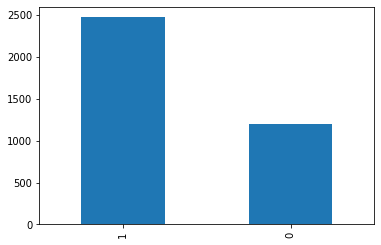

In [8]:
counts = df['label'].value_counts()
print(f"Count of label 0 (not_equivalent) is: {counts[0]} and for label 1 (equivalent) is: {counts[1]}","\n\n")
counts.plot.bar()

In [9]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
len(tokenizer)

50265

In [10]:
class glueDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):
      self.max_len = max_len 
      self.dataset = dataset
    
    def _truncate_pair_of_tokens(self, tokens_a, tokens_b, ):
      while True:
          total_length = len(tokens_a) + len(tokens_b)
          if total_length <= self.max_len - 3:
              break
          if len(tokens_a) > len(tokens_b):
              tokens_a.pop()
          else:
              tokens_b.pop()

    def __getitem__(self, idx):
      example = self.dataset[idx]
      tokens_a = tokenizer.tokenize(example["sentence1"])
      tokens_b = tokenizer.tokenize(example["sentence2"])
      self._truncate_pair_of_tokens(tokens_a, tokens_b)
      tokens = []
      #tokens.append("[CLS]")
      tokens.append(tokenizer.cls_token)
      for token in tokens_a:
          tokens.append(token)
      #tokens.append("[SEP]")
      tokens.append(tokenizer.sep_token) 
      for token in tokens_b:
          tokens.append(token)
      #tokens.append("[SEP]")
      tokens.append(tokenizer.sep_token)
      
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      input_mask = [1] * len(input_ids)
      while len(input_ids) < self.max_len:
          input_ids.append(0)
          input_mask.append(0)
      
      input_ids   = torch.tensor(input_ids, dtype=torch.int64).to(device)
      input_mask  = torch.tensor(input_mask, dtype=torch.float).to(device)
      label       = torch.tensor(example["label"], dtype=torch.int64).to(device)
      return (input_ids, input_mask, label)

    def __len__(self):
      return len(self.dataset)

In [11]:
batch_size = 32
max_seq_length = 128

In [12]:
train_dataset = glueDataset(raw_train_data, max_seq_length)
train_data_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)

In [13]:
val_dataset = glueDataset(raw_val_data, max_seq_length)
val_data_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

In [14]:
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 128)
        self.bn1 = torch.nn.LayerNorm(128)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(128, 2) 
        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.xavier_uniform_(self.l2.weight)
        
    def forward(self, input_ids, attention_mask):
        #input_ids=None, attention_mask=None, token_type_ids=None
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x

In [15]:
#object to hold out our results and to save and reload model and metrics file
class ResultsSaver():
  def __init__(self, train_len, val_len, output_path):
    self.train_losses = []
    self.val_losses = []
    self.steps = []

    self.best_val_loss = float('Inf')
    
    self.train_len = train_len
    self.val_len = val_len
    
    self.output_path = output_path
  
  def save_checkpoint(self, path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),'valid_loss': valid_loss}, self.output_path + path)

  def load_checkpoint(self, path, model):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

  def save_metrics(self, path):   
    state_dict = {'train_losses': self.train_losses,
                  'val_losses': self.val_losses,
                  'steps': self.steps}
    
    torch.save(state_dict, self.output_path + path)
  
  def load_metrics(self, path):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    return state_dict['train_losses'], state_dict['val_losses'], state_dict['steps']

  def update_train_val_loss(self, model, train_loss, val_loss, step, epoch, num_epochs):
    
    train_loss = train_loss / self.train_len
    val_loss = val_loss / self.val_len
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.steps.append(step)
    print('Epoch [{}/{}], step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}' .format(epoch+1, num_epochs, step, num_epochs * self.train_len, train_loss, val_loss))
    
    # checkpoint
    if self.best_val_loss > val_loss:
        self.best_val_loss = val_loss
        self.save_checkpoint('/model.pkl', model, self.best_val_loss)
        self.save_metrics('/metric.pkl')

In [16]:
# defin training procedure
def train(model, optimizer, train_data_loader, val_data_loader, results, scheduler = None, num_epochs = 5 , train_whole_model = False):
    step = 0
    best_val_loss = 1e9
    # if we want to train all the model (our added layer + roBERTa)
    if train_whole_model:
      for param in model.roberta.parameters():
        param.requires_grad = True
    # in case we just want to train our added layer.
    else:
      for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0.0                
        val_loss = 0.0
        for (input_ids, input_mask, y_true) in train_data_loader:
            y_pred = model(input_ids = input_ids, attention_mask = input_mask) 
            loss = torch.nn.CrossEntropyLoss()(y_pred, y_true)
            loss.backward()
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
            optimizer.zero_grad()
            # Update train loss and step
            train_loss += loss.item()
            step += batch_size

        model.eval()
        with torch.no_grad():                    
            for (input_ids, input_mask, y_true) in val_data_loader:
                y_pred = model(input_ids = input_ids, attention_mask = input_mask)
                loss = torch.nn.CrossEntropyLoss()(y_pred, y_true)
                val_loss += loss.item()
        # results.update_train_val_loss(model, train_loss, val_loss, step, epoch, num_epochs) 
        # train_loss /= len(train_data_loader.dataset)
        # val_loss /= len(val_data_loader.dataset)
        results.update_train_val_loss(model, train_loss, val_loss, step, epoch, num_epochs) 
        model.train()

    results.save_metrics('/metric.pkl')

In [17]:
output_path = 'here'

In [18]:
steps_per_epoch = len(train_dataset)
model = ROBERTAClassifier(0.4)
model = model.to(device)
# Main training loop
results = ResultsSaver(len(train_dataset), len(val_dataset), output_path)

In [19]:
NUM_EPOCHS_1 = 12
print(" ............. Training the added Layers only ............. ")
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,  num_warmup_steps=steps_per_epoch*1,  num_training_steps=steps_per_epoch*NUM_EPOCHS_1)

train(model=model, train_data_loader=train_data_loader, val_data_loader=val_data_loader, optimizer=optimizer, 
      results = results, scheduler=scheduler, num_epochs=NUM_EPOCHS_1, train_whole_model = False)

print(" ............. Training the whole Model ............. ")
NUM_EPOCHS_2 = 36
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2,  num_training_steps=steps_per_epoch*NUM_EPOCHS_2)

train(model=model,  train_data_loader=train_data_loader,  val_data_loader=val_data_loader,  optimizer=optimizer, 
      results = results,  scheduler=scheduler,  num_epochs=NUM_EPOCHS_2, train_whole_model=True)

 ............. Training the added Layers only ............. 
Epoch [1/12], step [3680/44016], Train Loss: 0.0277, Valid Loss: 0.0217
Epoch [2/12], step [7360/44016], Train Loss: 0.0248, Valid Loss: 0.0199
Epoch [3/12], step [11040/44016], Train Loss: 0.0242, Valid Loss: 0.0202
Epoch [4/12], step [14720/44016], Train Loss: 0.0244, Valid Loss: 0.0203
Epoch [5/12], step [18400/44016], Train Loss: 0.0240, Valid Loss: 0.0205
Epoch [6/12], step [22080/44016], Train Loss: 0.0240, Valid Loss: 0.0201
Epoch [7/12], step [25760/44016], Train Loss: 0.0241, Valid Loss: 0.0202
Epoch [8/12], step [29440/44016], Train Loss: 0.0234, Valid Loss: 0.0203
Epoch [9/12], step [33120/44016], Train Loss: 0.0233, Valid Loss: 0.0200
Epoch [10/12], step [36800/44016], Train Loss: 0.0224, Valid Loss: 0.0200
Epoch [11/12], step [40480/44016], Train Loss: 0.0223, Valid Loss: 0.0199
Epoch [12/12], step [44160/44016], Train Loss: 0.0215, Valid Loss: 0.0199
 ............. Training the whole Model ............. 
Epoch [

In [20]:
def truncate_pair_of_tokens(tokens_a, tokens_b, max_len):
      while True:
          total_length = len(tokens_a) + len(tokens_b)
          if total_length <= max_len - 3:
              break
          if len(tokens_a) > len(tokens_b):
              tokens_a.pop()
          else:
              tokens_b.pop()

In [21]:
def build_features(example, max_len = 128):
  tokens_a = tokenizer.tokenize(example["sentence1"])
  tokens_b = tokenizer.tokenize(example["sentence2"])
  truncate_pair_of_tokens(tokens_a, tokens_b, max_len)
  tokens = []
  #tokens.append("[CLS]")
  tokens.append(tokenizer.cls_token)
  for token in tokens_a:
      tokens.append(token)
  #tokens.append("[SEP]")
  tokens.append(tokenizer.sep_token) 
  for token in tokens_b:
      tokens.append(token)
  #tokens.append("[SEP]")
  tokens.append(tokenizer.sep_token)
  
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_mask = [1] * len(input_ids)
  while len(input_ids) < max_len:
      input_ids.append(0)
      input_mask.append(0)
  
  input_ids   = torch.tensor(input_ids, dtype=torch.int64).to(device)
  input_mask  = torch.tensor(input_mask, dtype=torch.float).to(device)
  return (input_ids, input_mask)

In [22]:
model = model.eval()

In [23]:
data = raw_train_data

In [24]:
final = 0
for i in range(len(data)):
  example = data[i]
  input_word_ids_test, input_masks_test = build_features(example)
  input_word_ids_test = input_word_ids_test.reshape(1, -1)
  input_masks_test = input_masks_test.reshape(1, -1)
  result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
  result = result[0].detach().cpu()
  result = torch.argmax(result).numpy()
  if example['label'] == result:
    final += 1

print(final/len(data))

0.9708287895310797


In [25]:
data = raw_test_data

In [26]:
final = 0
for i in range(len(data)):
  example = data[i]
  input_word_ids_test, input_masks_test = build_features(example)
  input_word_ids_test = input_word_ids_test.reshape(1, -1)
  input_masks_test = input_masks_test.reshape(1, -1)
  result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
  result = result[0].detach().cpu()
  result = torch.argmax(result).numpy()
  if example['label'] == result:
    final += 1

print(final/len(data))

0.8626086956521739


In [27]:
example = {
      'sentence1': "Syria is a small country with great kitchen",
      'sentence2': "Syria is a beautiful country with delicious kitchen",
}
input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result)
result = torch.argmax(result).numpy()
result

tensor([-4.0438,  2.4283])


array(1)

In [28]:
example = {
      'sentence1': "Syria is a small country with great kitchen",
      'sentence2': 'Itmo is a descent university, with great it experts'
}
input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result)
result = torch.argmax(result).numpy()
result

tensor([ 0.9444, -1.6423])


array(0)

In [29]:
example = raw_test_data[0]
print(example['sentence1'],'\n' ,example['sentence2'], '\n', example['label'])
input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result)
result = torch.argmax(result).numpy()
result

PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So . 
 Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So . 
 1
tensor([-3.3069,  1.6401])


array(1)

In [30]:
example = raw_test_data[425]
print(example['sentence1'],'\n' ,example['sentence2'], '\n', example['label'])
input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result)
result = torch.argmax(result).numpy()
result

The monkeys could track their progress by watching a schematic representation of the arm and its motions on a video screen . 
 The arm was kept in a separate room , but the monkeys could track their progress by watching a representation of the arm and its motions on a video screen . 
 0
tensor([ 1.5637, -2.7890])


array(0)